<a href="https://colab.research.google.com/github/gargi510/Wikipedia_Page_Views_Forecasting-AdEase/blob/main/adsense_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement  

AdEase is a digital advertising company that leverages AI to help businesses maximize engagement at minimal cost. Its end-to-end ad infrastructure is powered by three core AI modules – **Design, Dispense, and Decipher** – to deliver effective and economical advertising solutions.  

As part of the Data Science team at AdEase, the objective is to **analyze and forecast per-page view trends for Wikipedia pages** to optimize ad placements for clients across regions and languages. The dataset consists of **145,000 Wikipedia pages with daily view counts spanning 550 days**.  

The task is to:  
1. **Understand historical view patterns** across different Wikipedia pages.  
2. **Forecast future page views** to anticipate user engagement levels.  
3. **Segment results by language and region**, aligning with client requirements.  
4. Provide insights to **optimize ad placement strategies**, ensuring higher visibility and return on investment for clients.  

This project aims to build reliable forecasting models that can predict audience exposure across multilingual Wikipedia pages, thereby enabling AdEase to **strategically position advertisements where they are most impactful**.  


# Data Dictionary  

- **train_1.csv**  
  - Rows → Wikipedia articles  
  - Columns → Dates (daily views per article)  
  - `Page` format: `NAME_LANGUAGE.wikipedia.org_ACCESS_TYPE_ACCESS_ORIGIN`  

- **Exog_Campaign_eng.csv**  
  - Binary indicator for campaigns/events
  - `1` = campaign/event day, `0` = normal day  
  - Used as an exogenous variable in forecasting  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")


In [2]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Ad Sense/train_1.csv"

df = pd.read_csv(file_path)
df.head()


Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [3]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB
None
(145063, 551)


In [4]:
split_cols = df['Page'].str.rsplit('_', n=3, expand=True)

df['Page_Name'] = split_cols[0]
df['Language_Domain'] = split_cols[1]
df['Access_Type'] = split_cols[2]
df['Access_Origin'] = split_cols[3]

df['Language'] = df['Language_Domain'].str[:2]

df['Domain'] = df['Language_Domain'].str.split('.', n=1).str[1]

df[['Page', 'Page_Name', 'Language', 'Domain', 'Access_Type', 'Access_Origin']].head()


Page         Page_Name  \
0            2NE1_zh.wikipedia.org_all-access_spider              2NE1   
1             2PM_zh.wikipedia.org_all-access_spider               2PM   
2              3C_zh.wikipedia.org_all-access_spider                3C   
3         4minute_zh.wikipedia.org_all-access_spider           4minute   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  52_Hz_I_Love_You   

  Language         Domain Access_Type Access_Origin  
0       zh  wikipedia.org  all-access        spider  
1       zh  wikipedia.org  all-access        spider  
2       zh  wikipedia.org  all-access        spider  
3       zh  wikipedia.org  all-access        spider  
4       zh  wikipedia.org  all-access        spider

In [5]:
df[df['Language'] == 'ww'].head()

Page  2015-07-01  \
19611  "Keep_me_logged_in"_extended_to_one_year_www.m...         NaN   
19612  2017_wikitext_editor_www.mediawiki.org_all-acc...         NaN   
19613  2017_wikitext_editor/Feedback_www.mediawiki.or...         NaN   
19614        API_www.mediawiki.org_all-access_all-agents       528.0   
19615  API:Account_creation_www.mediawiki.org_all-acc...        37.0   

       2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  \
19611         NaN         NaN         NaN         NaN         NaN         NaN   
19612         NaN         NaN         NaN         NaN         NaN         NaN   
19613         NaN         NaN         NaN         NaN         NaN         NaN   
19614       587.0       634.0       483.0       510.0       559.0       625.0   
19615        38.0        46.0        41.0        79.0        91.0       100.0   

       2015-07-08  2015-07-09  ...  2016-12-28  2016-12-29  2016-12-30  \
19611         NaN         NaN  ...        10.0        14.0         7.0   
19612         NaN         NaN  ...        52.0        43.0       100.0   
19613         NaN         NaN  ...        48.0        32.0        41.0   
19614       594.0       565.0  ...       334.0       351.0       358.0   
19615        54.0        43.0  ...        38.0        28.0        45.0   

       2016-12-31                                 Page_Name  \
19611        12.0  "Keep_me_logged_in"_extended_to_one_year   
19612        73.0                      2017_wikitext_editor   
19613        19.0             2017_wikitext_editor/Feedback   
19614       275.0                                       API   
19615        41.0                      API:Account_creation   

         Language_Domain  Access_Type  Access_Origin  Language         Domain  
19611  www.mediawiki.org   all-access     all-agents        ww  mediawiki.org  
19612  www.mediawiki.org   all-access     all-agents        ww  mediawiki.org  
19613  www.mediawiki.org   all-access     all-agents        ww  mediawiki.org  
19614  www.mediawiki.org   all-access     all-agents        ww  mediawiki.org  
19615  www.mediawiki.org   all-access     all-agents        ww  mediawiki.org  

[5 rows x 557 columns]

API links special links

In [6]:
df.drop(columns=['Page','Language_Domain'], inplace=True)
df.head()

2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0        18.0        11.0         5.0        13.0        14.0         9.0   
1        11.0        14.0        15.0        18.0        11.0        13.0   
2         1.0         0.0         1.0         1.0         0.0         4.0   
3        35.0        13.0        10.0        94.0         4.0        26.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-27  \
0         9.0        22.0        26.0        24.0  ...        20.0   
1        22.0        11.0        10.0         4.0  ...        30.0   
2         0.0         3.0         4.0         4.0  ...         4.0   
3        14.0         9.0        11.0        16.0  ...        11.0   
4         NaN         NaN         NaN         NaN  ...        11.0   

   2016-12-28  2016-12-29  2016-12-30  2016-12-31         Page_Name  \
0        22.0        19.0        18.0        20.0              2NE1   
1        52.0        45.0        26.0        20.0               2PM   
2         6.0         3.0         4.0        17.0                3C   
3        17.0        19.0        10.0        11.0           4minute   
4        27.0        13.0        36.0        10.0  52_Hz_I_Love_You   

   Access_Type  Access_Origin  Language         Domain  
0   all-access         spider        zh  wikipedia.org  
1   all-access         spider        zh  wikipedia.org  
2   all-access         spider        zh  wikipedia.org  
3   all-access         spider        zh  wikipedia.org  
4   all-access         spider        zh  wikipedia.org  

[5 rows x 555 columns]

In [7]:
df.shape

(145063, 555)

In [8]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Ad Sense/Exog_Campaign_eng"

df2 = pd.read_csv(file_path)
df2.head()


Exog
0     0
1     0
2     0
3     0
4     0

In [9]:
df2.shape

(550, 1)

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Exog    550 non-null    int64
dtypes: int64(1)
memory usage: 4.4 KB


In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df.dtypes.sample(10)

2016-04-30    float64
2016-08-27    float64
2016-01-23    float64
2016-12-17    float64
2016-06-15    float64
2015-10-12    float64
2016-12-04    float64
2015-09-22    float64
2016-10-01    float64
2016-09-16    float64
dtype: object

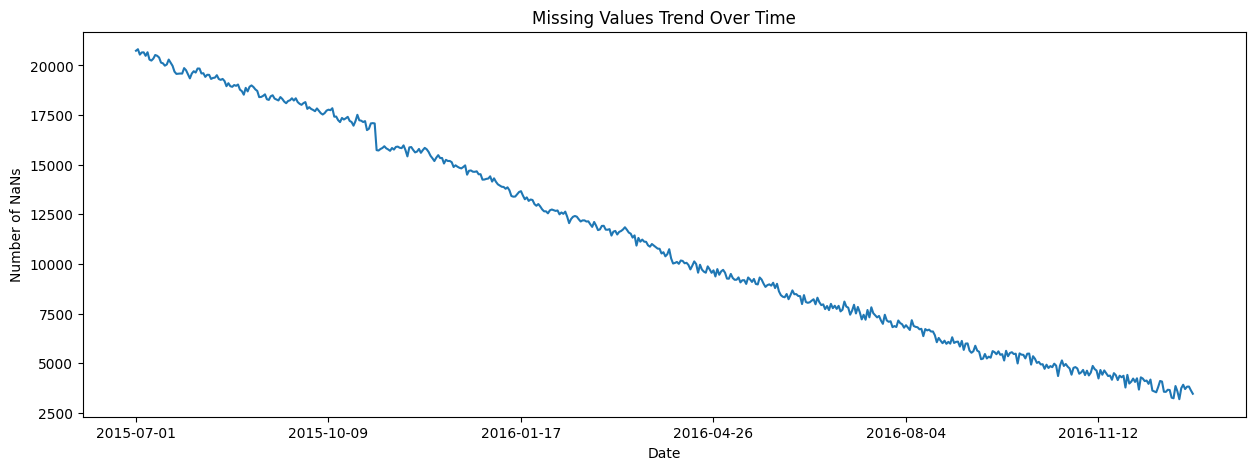

In [13]:
date_cols = df.columns[:-5]   # all except last 5 metadata columns
missing_trend = df[date_cols].isna().sum()
import matplotlib.pyplot as plt

missing_trend.plot(figsize=(15,5))
plt.title("Missing Values Trend Over Time")
plt.ylabel("Number of NaNs")
plt.xlabel("Date")
plt.show()


In [14]:
print("First 10 days missing:", missing_trend.head(10).mean())
print("Last 10 days missing:", missing_trend.tail(10).mean())

First 10 days missing: 20544.0
Last 10 days missing: 3673.7


Early period (2015 start):

Many pages didn’t exist yet (they were created later).

So their page views are recorded as NaN because there was nothing to track.

Example: a Wikipedia article created in 2016 will show NaN for all 2015 dates.

Later period (2016 end):

By then, most pages already exist.

Fewer NaNs, because almost all pages have traffic data.

The smaller remaining NaNs could be logging issues, bot filtering, or data pipeline errors, not page non-existence.
dataset becomes more reliable over time
Over time, more pages exist, and missingness shifts from being about page creation → to being about random missing logs.

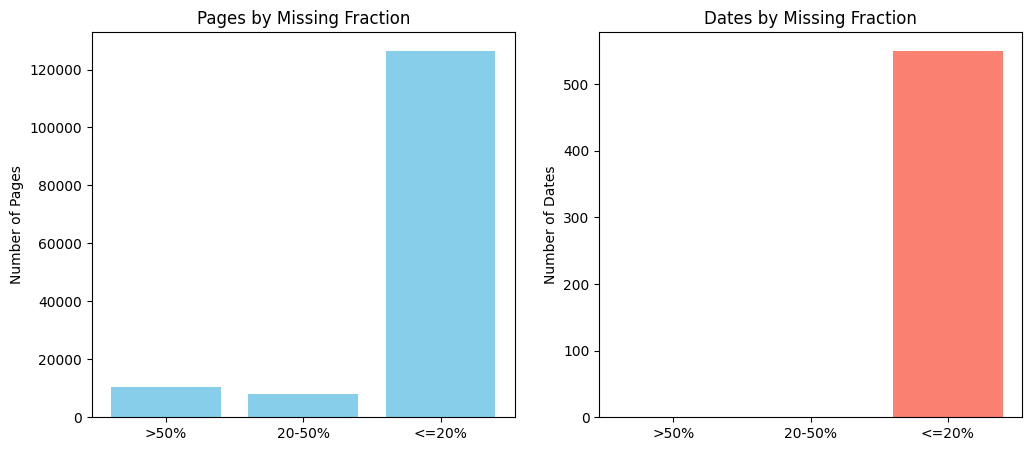

      Bin   Pages  Dates
0    >50%   10484      0
1  20-50%    8052      0
2   <=20%  126527    550


In [15]:
date_cols = df.columns[:-5]
page_missing_frac = df[date_cols].isna().mean(axis=1)
daily_missing_frac = df[date_cols].isna().mean(axis=0)

def categorize_missing(x):
    if x > 0.5:
        return '>50%'
    elif x > 0.2:
        return '20-50%'
    else:
        return '<=20%'

page_bins = page_missing_frac.apply(categorize_missing).value_counts().reindex(['>50%', '20-50%', '<=20%'], fill_value=0)
date_bins = daily_missing_frac.apply(categorize_missing).value_counts().reindex(['>50%', '20-50%', '<=20%'], fill_value=0)

fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].bar(page_bins.index, page_bins.values, color='skyblue')
axs[0].set_title("Pages by Missing Fraction")
axs[0].set_ylabel("Number of Pages")
axs[1].bar(date_bins.index, date_bins.values, color='salmon')
axs[1].set_title("Dates by Missing Fraction")
axs[1].set_ylabel("Number of Dates")
plt.show()

summary_table = pd.DataFrame({
    "Bin": ['>50%', '20-50%', '<=20%'],
    "Pages": page_bins.values,
    "Dates": date_bins.values
})

print(summary_table)


Drop pages with >50% missing → too sparse to model.

Fill early NaNs (before first valid value) with 0 → structural missing (page didn’t exist).

Interpolate middle/late NaNs → smooth sporadic gaps in the series.

Forward/backward fill edge NaNs → handle any remaining missing values.

Focus on pages, not dates → dates are mostly complete.

In [16]:
def handle_page_missing_values(df, date_cols):
    # Convert date columns to numeric
    df[date_cols] = df[date_cols].apply(pd.to_numeric, errors='coerce')

    # Step 1: Drop pages with >50% missing
    df['missing_fraction'] = df[date_cols].isna().mean(axis=1)
    pages_dropped = df[df['missing_fraction'] > 0.5].shape[0]
    df = df[df['missing_fraction'] <= 0.5]

    # Step 2: Fill early NaNs with 0
    def fill_early_nans(row):
        values = row.values
        first_valid_idx = np.argmax(~pd.isna(values))
        values[:first_valid_idx] = 0
        return values

    df[date_cols] = df[date_cols].apply(fill_early_nans, axis=1, result_type='expand')

    # Step 3: Interpolate remaining NaNs
    df[date_cols] = df[date_cols].interpolate(axis=1, method='linear')

    # Step 4: Forward/backward fill edge NaNs
    df[date_cols] = df[date_cols].ffill(axis=1).bfill(axis=1)

    df = df.drop(columns=['missing_fraction'])
    print(f"Pages dropped (>50% missing): {pages_dropped}")
    return df

# Apply the function
df_cleaned = handle_page_missing_values(df, date_cols)

# Verify no missing values remain
print("Total missing values after handling:", df_cleaned[date_cols].isna().sum().sum())


/tmp/ipython-input-1172835366.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['missing_fraction'] = df[date_cols].isna().mean(axis=1)
/tmp/ipython-input-1172835366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_cols] = df[date_cols].apply(fill_early_nans, axis=1, result_type='expand')
/tmp/ipython-input-1172835366.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Pages dropped (>50% missing): 10484
Total missing values after handling: 0


In [17]:
total_nan = df_cleaned.isna().sum().sum()
print("Total number of NaNs in the dataset:", total_nan)


Total number of NaNs in the dataset: 0


In [18]:
print(df_cleaned.info())
print(df_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
Index: 134579 entries, 0 to 145020
Columns: 555 entries, 2015-07-01 to Domain
dtypes: float64(550), object(5)
memory usage: 570.9+ MB
None
   2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0        18.0        11.0         5.0        13.0        14.0         9.0   
1        11.0        14.0        15.0        18.0        11.0        13.0   
2         1.0         0.0         1.0         1.0         0.0         4.0   
3        35.0        13.0        10.0        94.0         4.0        26.0   
5        12.0         7.0         4.0         5.0        20.0         8.0   

   2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  2016-12-27  \
0         9.0        22.0        26.0        24.0  ...        20.0   
1        22.0        11.0        10.0         4.0  ...        30.0   
2         0.0         3.0         4.0         4.0  ...         4.0   
3        14.0         9.0        11.0        16.0  ...        11.0   
5         

## EDA

In [19]:
language_map = {
    'en': 'English',
    'ja': 'Japanese',
    'de': 'German',
    'fr': 'French',
    'zh': 'Chinese',
    'ru': 'Russian',
    'es': 'Spanish',
    'co': 'Corsican',
    'ww': 'Unknown'
}

df_cleaned['Language_Full'] = df_cleaned['Language'].map(language_map)
language_counts_full = df_cleaned['Language_Full'].value_counts()

/tmp/ipython-input-1475658296.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cleaned['Language_Full'] = df_cleaned['Language'].map(language_map)


In [20]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Pages by Language", "Pages by Domain",
                                    "Pages by Access Type", "Pages by Access Origin"))

language_counts = df_cleaned['Language_Full'].value_counts()
language_percent = (language_counts / language_counts.sum() * 100).sort_values()

domain_counts = df_cleaned['Domain'].value_counts()
domain_percent = (domain_counts / domain_counts.sum() * 100).sort_values()

access_type_counts = df_cleaned['Access_Type'].value_counts()
access_type_percent = (access_type_counts / access_type_counts.sum() * 100).sort_values()

access_origin_counts = df_cleaned['Access_Origin'].value_counts()
access_origin_percent = (access_origin_counts / access_origin_counts.sum() * 100).sort_values()

fig.add_trace(go.Bar(x=language_percent.values, y=language_percent.index, orientation='h',
                     text=[f"{round(v)}%" for v in language_percent.values], textposition='auto', marker_color='skyblue'),
              row=1, col=1)

fig.add_trace(go.Bar(x=domain_percent.values, y=domain_percent.index, orientation='h',
                     text=[f"{round(v)}%" for v in domain_percent.values], textposition='auto', marker_color='salmon'),
              row=1, col=2)

fig.add_trace(go.Bar(x=access_type_percent.values, y=access_type_percent.index, orientation='h',
                     text=[f"{round(v)}%" for v in access_type_percent.values], textposition='auto', marker_color='lightgreen'),
              row=2, col=1)

fig.add_trace(go.Bar(x=access_origin_percent.values, y=access_origin_percent.index, orientation='h',
                     text=[f"{round(v)}%" for v in access_origin_percent.values], textposition='auto', marker_color='plum'),
              row=2, col=2)

fig.update_layout(height=800, width=1200, showlegend=False, title_text="Wikipedia Pages Metadata Distribution (Percentage)")
fig.show()


In [21]:
overall_ts = df_cleaned[date_cols].sum()
overall_ts.index = pd.to_datetime(overall_ts.index)

overall_ts_daily = overall_ts
overall_ts_weekly = overall_ts.resample('W', label='left').sum()
overall_ts_monthly = overall_ts.resample('M').sum()

fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=("Daily Overall Views", "Weekly Overall Views", "Monthly Overall Views")
)

fig.add_trace(go.Scatter(
    x=overall_ts_daily.index,
    y=overall_ts_daily.values,
    mode='lines',
    name='Daily'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=overall_ts_weekly.index,
    y=overall_ts_weekly.values,
    mode='lines',
    name='Weekly',
    line=dict(color='orange')
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=overall_ts_monthly.index,
    y=overall_ts_monthly.values,
    mode='lines',
    name='Monthly',
    line=dict(color='green')
), row=3, col=1)

fig.update_layout(
    height=900, width=1200,
    title_text="Overall Wikipedia Views: Daily, Weekly, Monthly",
    margin=dict(l=60, r=20, t=80, b=50)
)
fig.show()

/tmp/ipython-input-2800387840.py:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [22]:
date_cols = [col for col in df_cleaned.columns if col[:4].isdigit()]

valid_langs = df_cleaned[~df_cleaned['Language_Full'].isin(['Unknown'])]
language_ts = valid_langs.groupby('Language_Full')[date_cols].sum().T
language_ts.index = pd.to_datetime(language_ts.index)

language_weekly = language_ts.resample('W', label='left').sum()
language_monthly = language_ts.resample('M').sum()

fig = make_subplots(
    rows=3, cols=1, shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=("Daily Views by Language",
                    "Weekly Views by Language",
                    "Monthly Views by Language")
)

colors = px.colors.qualitative.Plotly

for i, lang in enumerate(language_ts.columns):
    fig.add_trace(go.Scatter(
        x=language_ts.index,
        y=language_ts[lang],
        mode='lines',
        name=lang,
        legendgroup=lang,
        line=dict(color=colors[i % len(colors)])
    ), row=1, col=1)

for i, lang in enumerate(language_ts.columns):
    fig.add_trace(go.Scatter(
        x=language_weekly.index,
        y=language_weekly[lang],
        mode='lines',
        name=lang,
        legendgroup=lang,
        showlegend=False,
        line=dict(color=colors[i % len(colors)])
    ), row=2, col=1)

for i, lang in enumerate(language_ts.columns):
    fig.add_trace(go.Scatter(
        x=language_monthly.index,
        y=language_monthly[lang],
        mode='lines',
        name=lang,
        legendgroup=lang,
        showlegend=False,
        line=dict(color=colors[i % len(colors)])
    ), row=3, col=1)

fig.update_layout(
    height=1000, width=1200,
    title_text="Wikipedia Views by Language (Daily, Weekly, Monthly)",
    margin=dict(l=60, r=20, t=80, b=50)
)
fig.show()


/tmp/ipython-input-3134053572.py:13: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [23]:
date_cols = [col for col in df_cleaned.columns if col[:4].isdigit()]

access_ts = df_cleaned.groupby('Access_Type')[date_cols].sum()
access_ts_T = access_ts.T
access_ts_T.index = pd.to_datetime(access_ts_T.index)

access_ts_weekly = access_ts_T.resample('W', label='left').sum()
access_ts_monthly = access_ts_T.resample('M').sum()

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.08,
    subplot_titles=("Daily Views by Access Type",
                    "Weekly Views by Access Type",
                    "Monthly Views by Access Type")
)

for access in access_ts.index:
    fig.add_trace(go.Scatter(
        x=access_ts_T.index,
        y=access_ts_T[access].values,
        mode='lines',
        name=access,
        legendgroup=access
    ), row=1, col=1)

for access in access_ts.index:
    fig.add_trace(go.Scatter(
        x=access_ts_weekly.index,
        y=access_ts_weekly[access].values,
        mode='lines',
        name=access,
        legendgroup=access,
        showlegend=False
    ), row=2, col=1)

for access in access_ts.index:
    fig.add_trace(go.Scatter(
        x=access_ts_monthly.index,
        y=access_ts_monthly[access].values,
        mode='lines',
        name=access,
        legendgroup=access,
        showlegend=False
    ), row=3, col=1)

fig.update_layout(
    height=900, width=1200,
    title_text="Wikipedia Views by AcAcess Type: Daily, Weekly, Monthly",
    margin=dict(l=60, r=20, t=80, b=50)
)
fig.show()

/tmp/ipython-input-922603952.py:12: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



ADF Statistic: -2.3515, p-value: 0.1559


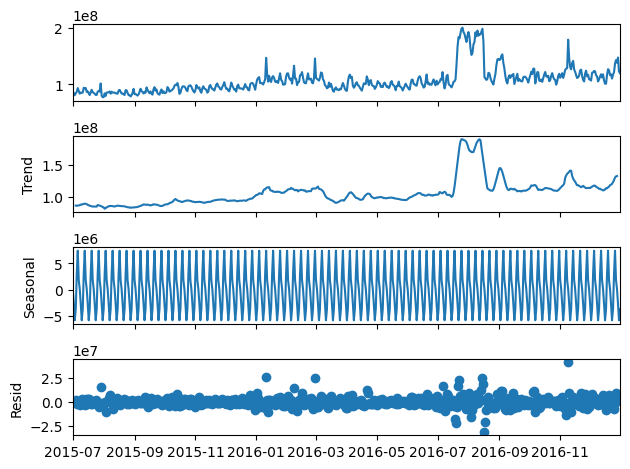

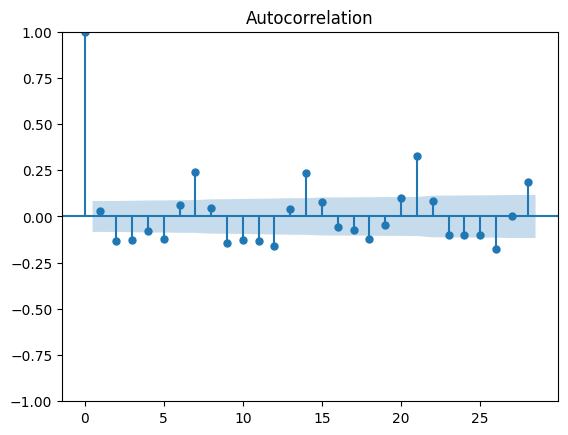

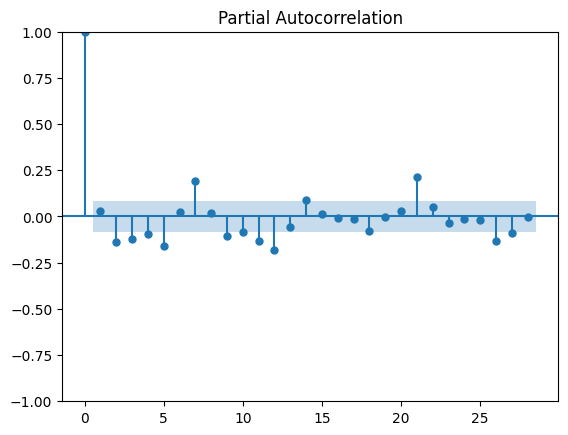

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -9296.227
Date:                           Thu, 25 Sep 2025   AIC                          18604.453
Time:                                   13:57:46   BIC                          18630.225
Sample:                               07-01-2015   HQIC                         18614.531
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Exog        2.277e+07   1.34e-09    1.7e+16      0.000    2.28e+07    2.28e+07
ar.L1          0.9138      0.041     22.469

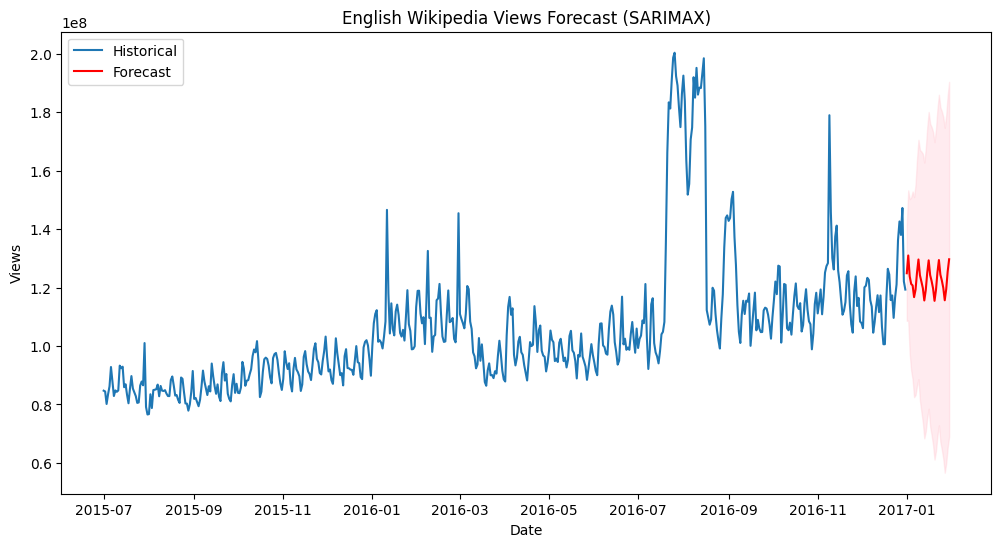

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/6ni474uq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/lxkf5pjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59810', 'data', 'file=/tmp/tmpz_ik_iyh/6ni474uq.json', 'init=/tmp/tmpz_ik_iyh/lxkf5pjd.json', 'output', 'file=/tmp/tmpz_ik_iyh/prophet_modelo3ccefhi/prophet_model-20250925135747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:57:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:57:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


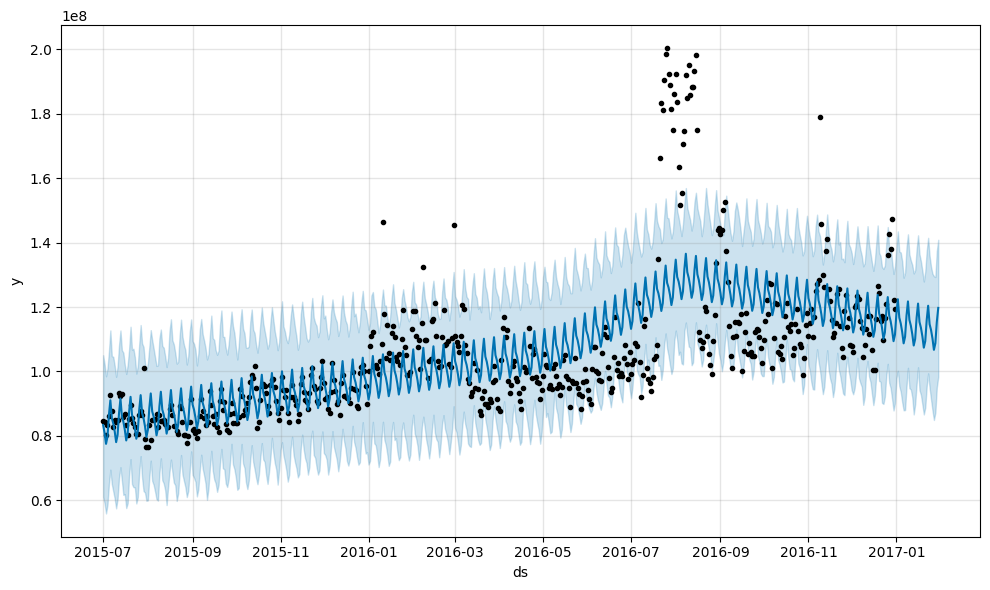

In [25]:
# --- Parameters ---
forecast_steps = 30
seasonal_period = 7

# --- Filter English pages ---
date_cols = [col for col in df_cleaned.columns if col[:4].isdigit()]
df_eng = df_cleaned[df_cleaned['Language_Full'] == 'English']

# Aggregate views across English pages
ts_eng = df_eng[date_cols].sum()
ts_eng.index = pd.to_datetime(ts_eng.index)


# Align campaign indicators with time series dates
df2.index = ts_eng.index[:len(df2)]   # assign dates from ts_eng
exog = df2['Exog'].reindex(ts_eng.index).fillna(0)  # pad with 0s if needed

# --- Stationarity check ---
result = adfuller(ts_eng)
print(f'ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}')

# Differencing if non-stationary
ts_diff = ts_eng.diff().dropna() if result[1] > 0.05 else ts_eng.copy()

# --- Decomposition ---
decomp = seasonal_decompose(ts_eng, model='additive', period=seasonal_period)
decomp.plot()
plt.show()

# --- ACF & PACF ---
plot_acf(ts_diff)
plot_pacf(ts_diff)
plt.show()

# --- SARIMAX modeling ---
model = SARIMAX(
    ts_eng,
    order=(1,1,1),
    seasonal_order=(1,1,1,seasonal_period),
    exog=exog
)
result_sarimax = model.fit(disp=False)
print(result_sarimax.summary())

# --- SARIMAX Forecast ---
exog_forecast = pd.Series(
    [0] * forecast_steps,
    index=pd.date_range(
        start=ts_eng.index[-1] + pd.Timedelta(days=1),
        periods=forecast_steps,
        freq="D"
    )
)

forecast = result_sarimax.get_forecast(steps=forecast_steps, exog=exog_forecast)
forecast_df = forecast.summary_frame()

plt.figure(figsize=(12,6))
plt.plot(ts_eng, label='Historical')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(
    forecast_df.index,
    forecast_df['mean_ci_lower'],
    forecast_df['mean_ci_upper'],
    color='pink',
    alpha=0.3
)
plt.title('English Wikipedia Views Forecast (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.show()

# --- Prophet modeling ---
prophet_df = pd.DataFrame({'ds': ts_eng.index, 'y': ts_eng.values})
m = Prophet()
m.fit(prophet_df)

future = m.make_future_dataframe(periods=forecast_steps)
forecast_prophet = m.predict(future)
fig = m.plot(forecast_prophet)
plt.show()



===== Forecasting for Chinese =====
Chinese | ADF: -1.9058, p-value: 0.3294


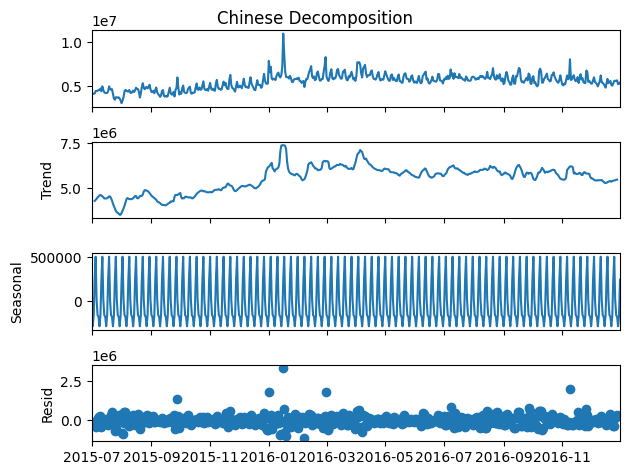

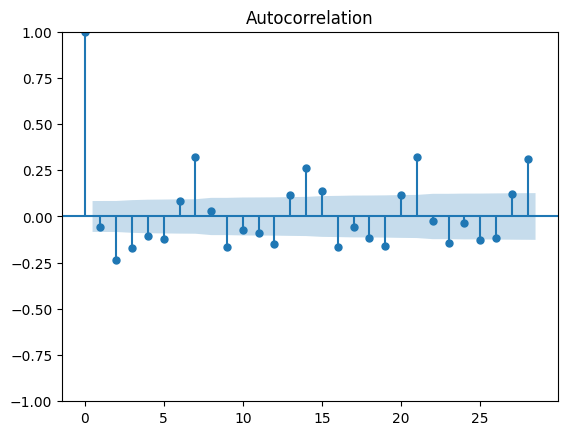

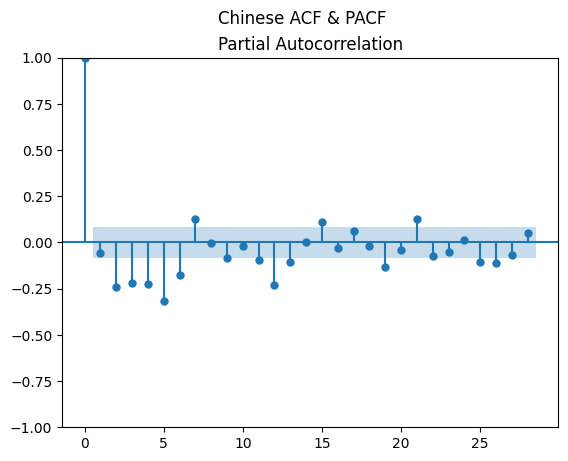

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7835.175
Date:                           Thu, 25 Sep 2025   AIC                          15680.350
Time:                                   14:12:18   BIC                          15701.826
Sample:                               07-01-2015   HQIC                         15688.748
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6123      0.111      5.528      0.000       0.395       0.829
ma.L1         -0.8558      0.095     -9.003

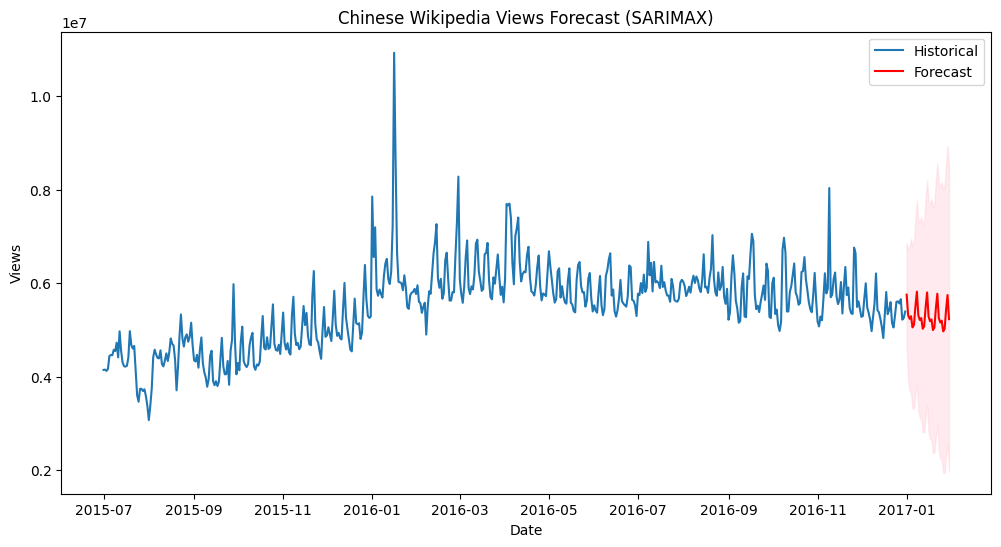

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/4kuah4m4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/l0ndh229.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70333', 'data', 'file=/tmp/tmpz_ik_iyh/4kuah4m4.json', 'init=/tmp/tmpz_ik_iyh/l0ndh229.json', 'output', 'file=/tmp/tmpz_ik_iyh/prophet_modelk4_4fhcb/prophet_model-20250925141218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


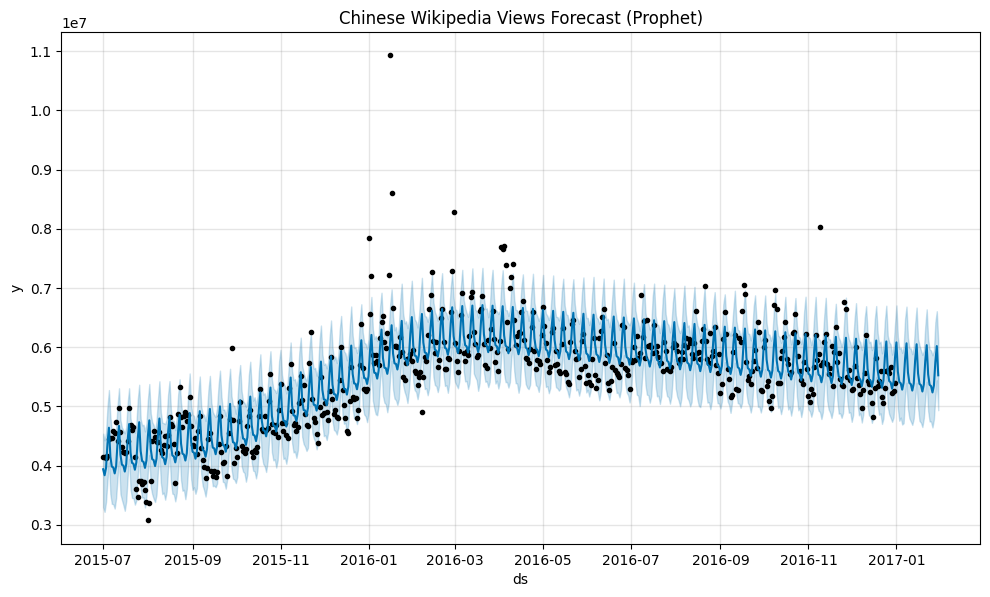


===== Forecasting for French =====
French | ADF: -2.9516, p-value: 0.0397


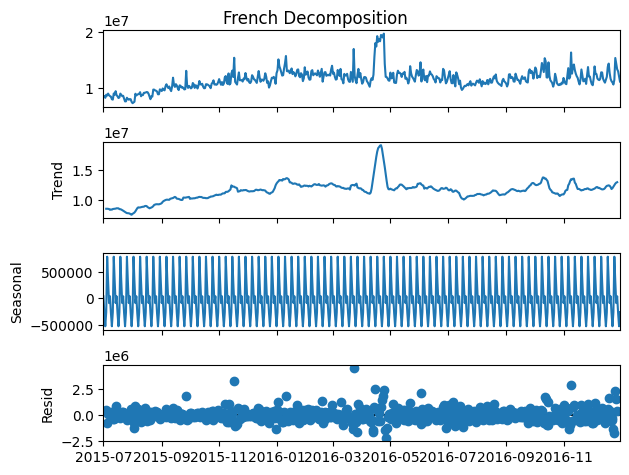

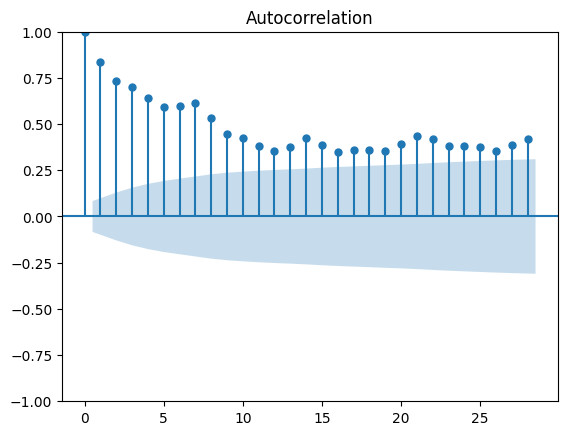

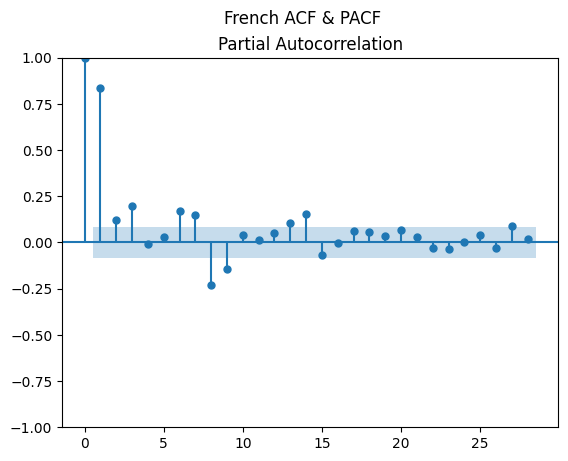

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8224.749
Date:                           Thu, 25 Sep 2025   AIC                          16459.499
Time:                                   14:12:20   BIC                          16480.975
Sample:                               07-01-2015   HQIC                         16467.897
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2248      0.235      0.958      0.338      -0.235       0.685
ma.L1         -0.4741      0.225     -2.103

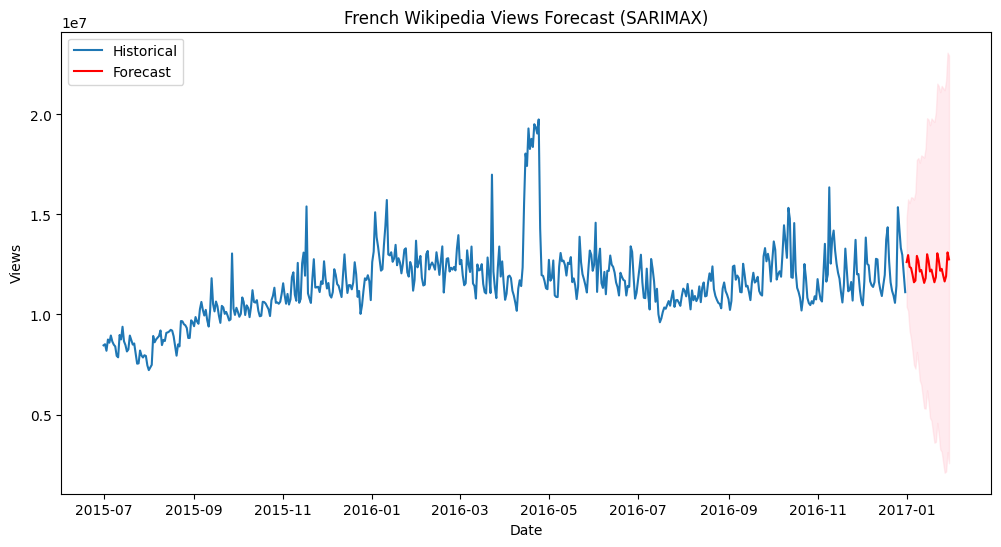

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/70qf4p09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/h2ca7h7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38587', 'data', 'file=/tmp/tmpz_ik_iyh/70qf4p09.json', 'init=/tmp/tmpz_ik_iyh/h2ca7h7s.json', 'output', 'file=/tmp/tmpz_ik_iyh/prophet_modelh8eufn_r/prophet_model-20250925141221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


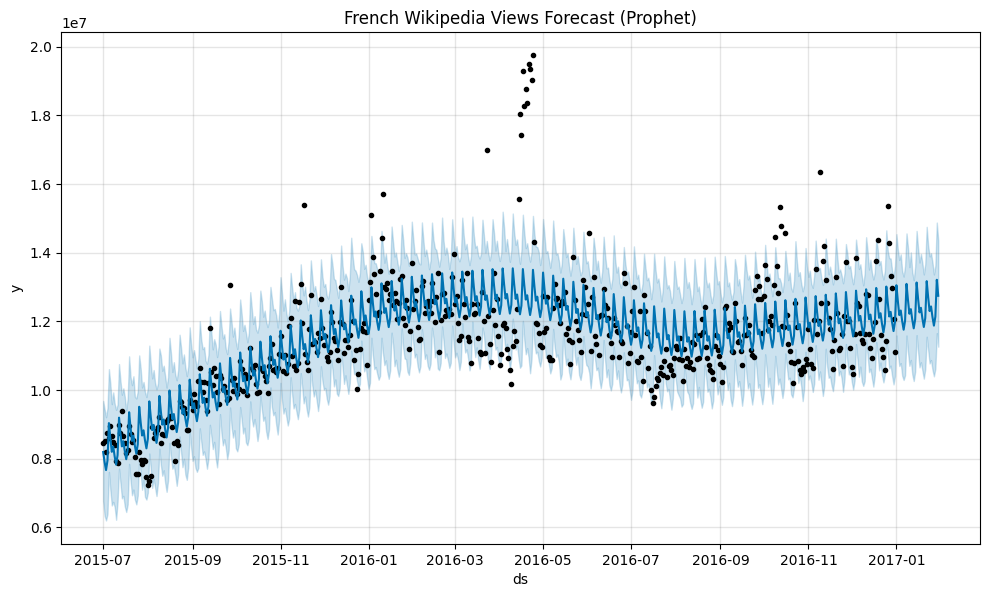


===== Forecasting for Corsican =====
Corsican | ADF: -3.1578, p-value: 0.0226


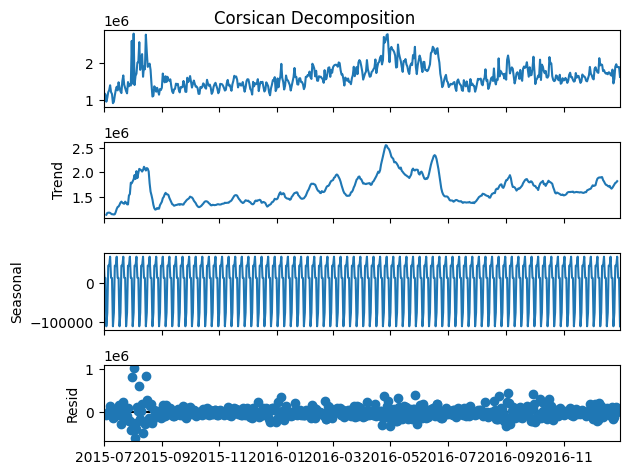

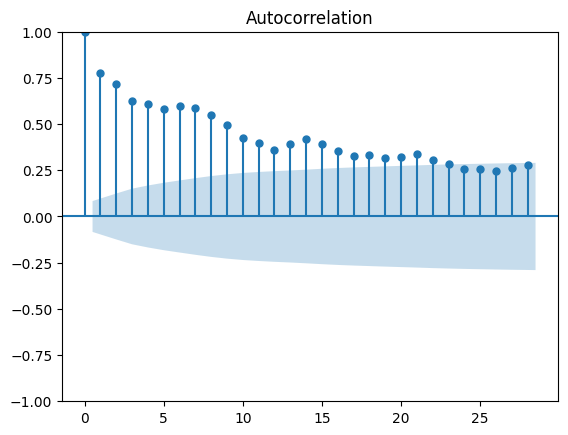

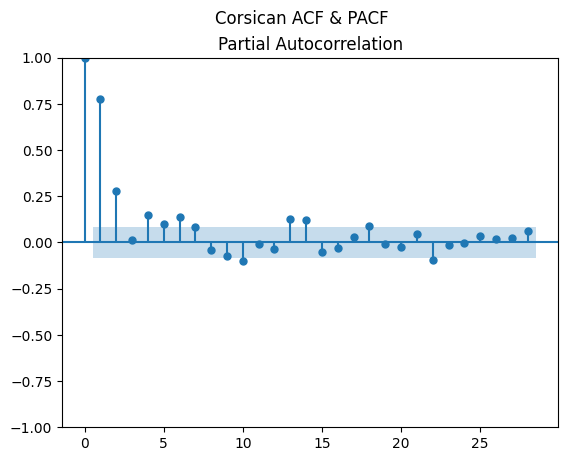

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7389.894
Date:                           Thu, 25 Sep 2025   AIC                          14789.788
Time:                                   14:12:23   BIC                          14811.264
Sample:                               07-01-2015   HQIC                         14798.186
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0634      0.102      0.623      0.533      -0.136       0.263
ma.L1         -0.5153      0.094     -5.488

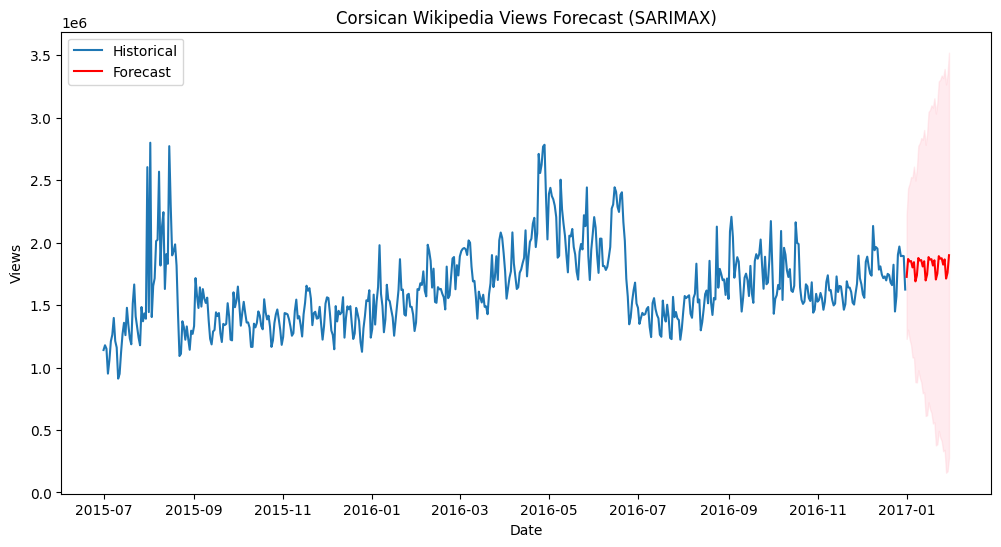

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/r8wna6dw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/q8_bb0i5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23784', 'data', 'file=/tmp/tmpz_ik_iyh/r8wna6dw.json', 'init=/tmp/tmpz_ik_iyh/q8_bb0i5.json', 'output', 'file=/tmp/tmpz_ik_iyh/prophet_modely70u_blz/prophet_model-20250925141223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


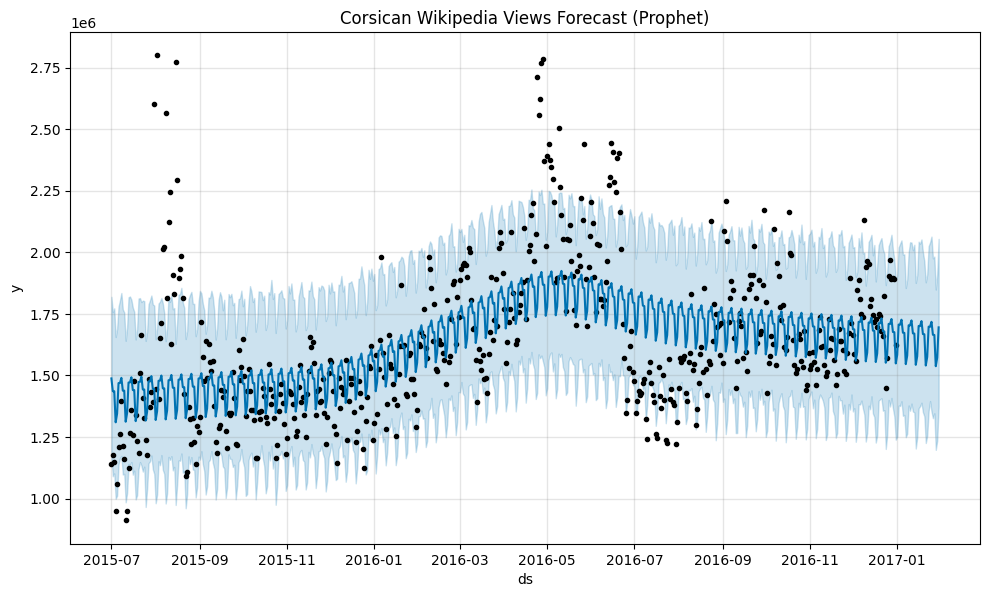


===== Forecasting for Russian =====
Russian | ADF: -3.9416, p-value: 0.0017


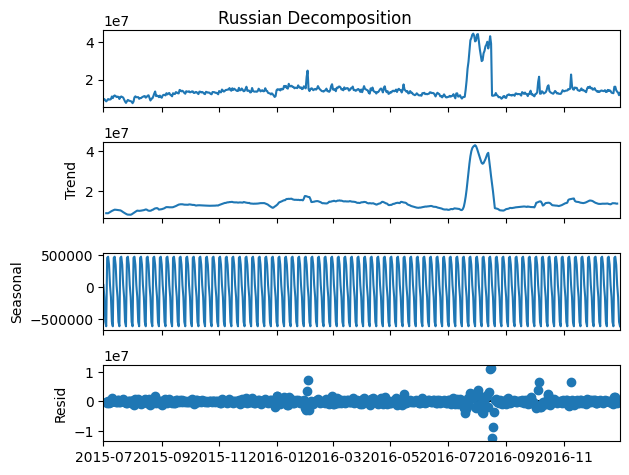

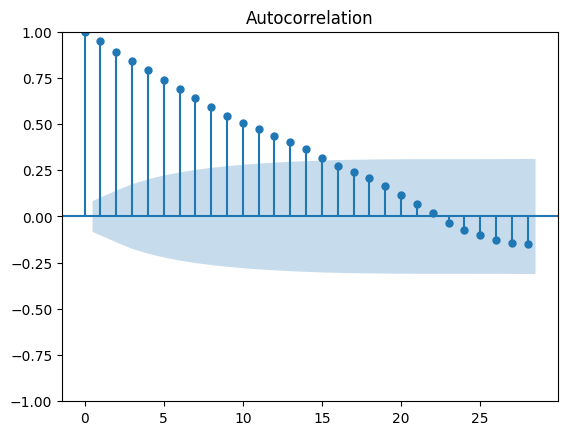

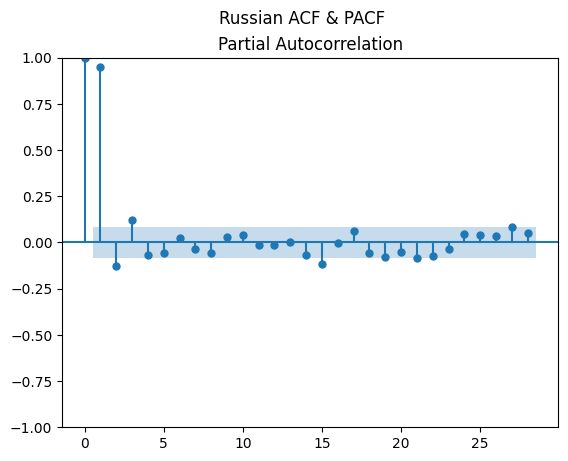

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8627.698
Date:                           Thu, 25 Sep 2025   AIC                          17265.396
Time:                                   14:12:27   BIC                          17286.872
Sample:                               07-01-2015   HQIC                         17273.794
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4073      0.422     -0.964      0.335      -1.235       0.421
ma.L1          0.5450      0.425      1.283

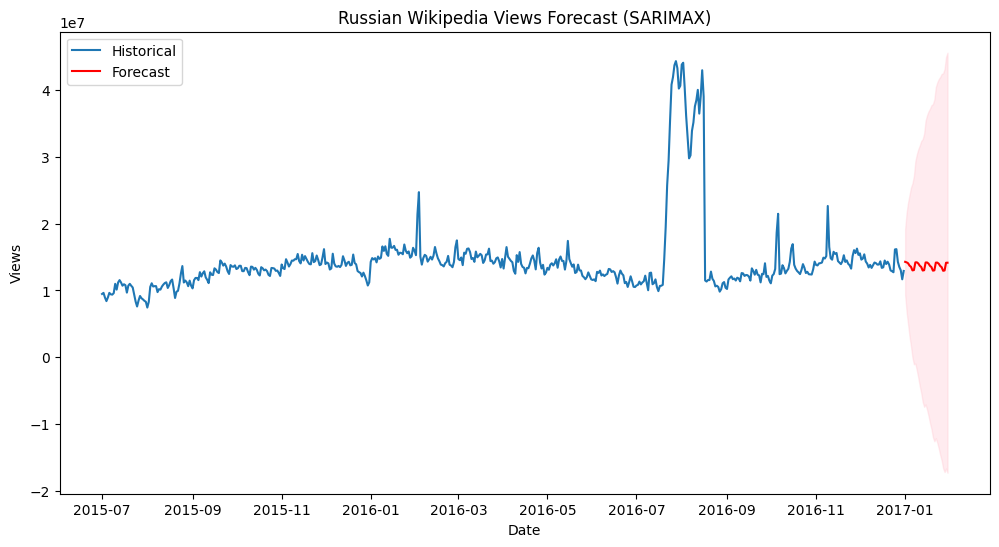

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/jttb_f9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/k0f39lqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61063', 'data', 'file=/tmp/tmpz_ik_iyh/jttb_f9y.json', 'init=/tmp/tmpz_ik_iyh/k0f39lqq.json', 'output', 'file=/tmp/tmpz_ik_iyh/prophet_modelll1n19vk/prophet_model-20250925141228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


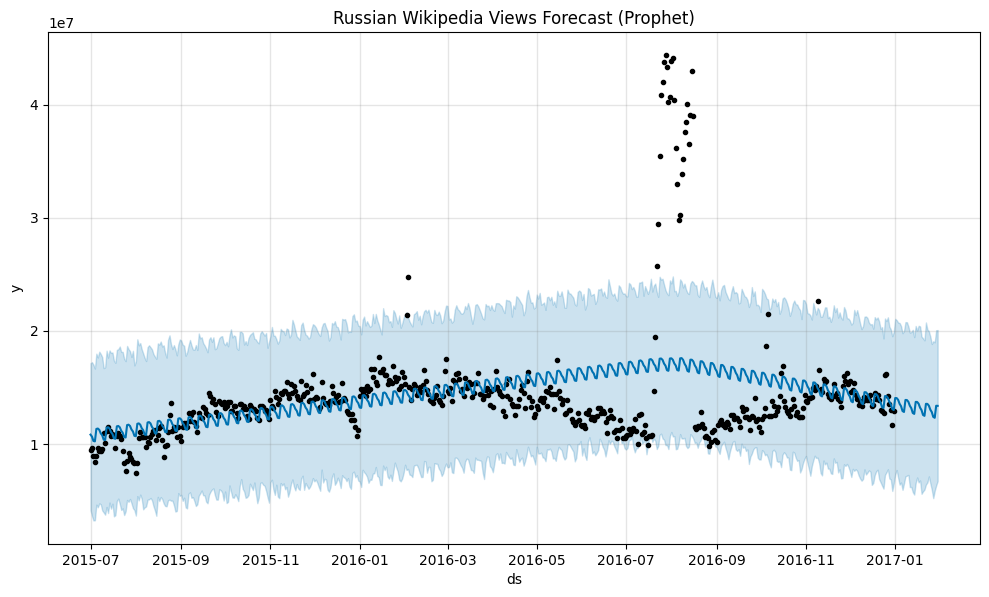


===== Forecasting for German =====
German | ADF: -2.4048, p-value: 0.1404


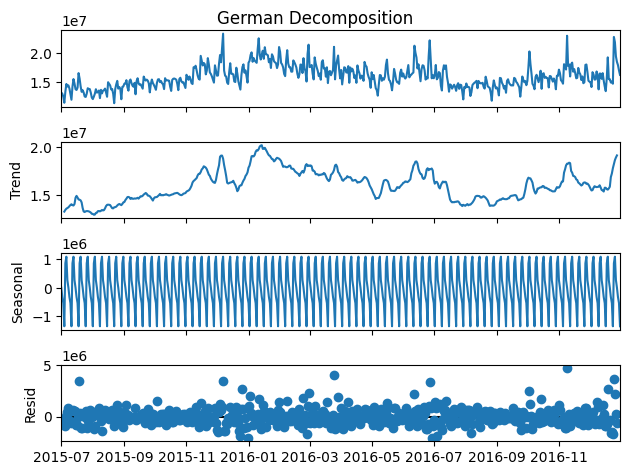

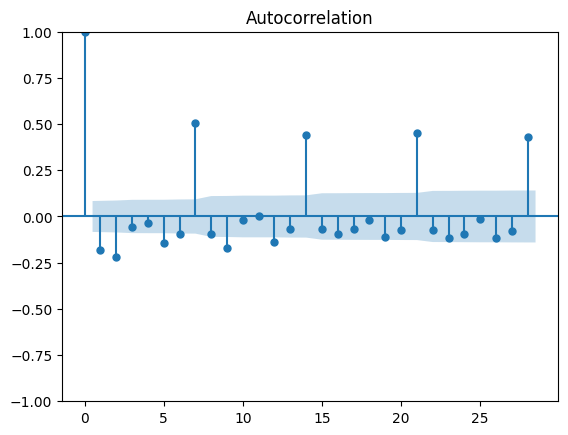

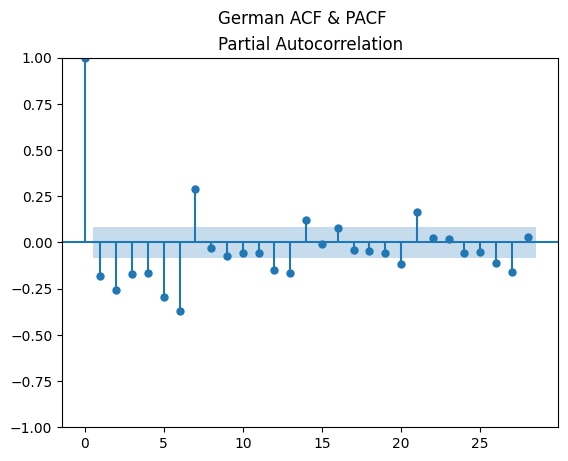

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8317.950
Date:                           Thu, 25 Sep 2025   AIC                          16645.899
Time:                                   14:12:30   BIC                          16667.376
Sample:                               07-01-2015   HQIC                         16654.297
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5370      0.124      4.317      0.000       0.293       0.781
ma.L1         -0.7653      0.105     -7.282

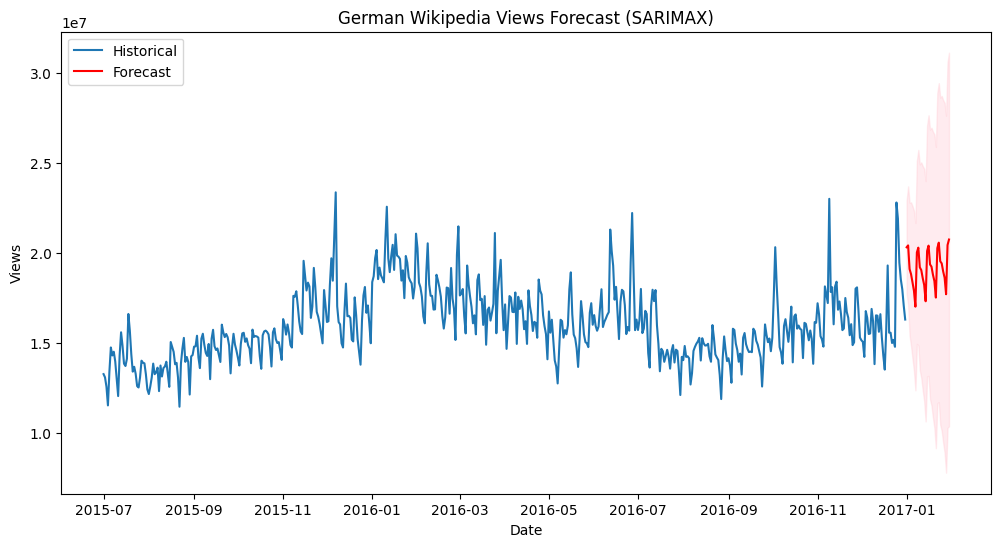

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/4hkubvbx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/3c84zxx1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24483', 'data', 'file=/tmp/tmpz_ik_iyh/4hkubvbx.json', 'init=/tmp/tmpz_ik_iyh/3c84zxx1.json', 'output', 'file=/tmp/tmpz_ik_iyh/prophet_modelylfs3wqf/prophet_model-20250925141230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


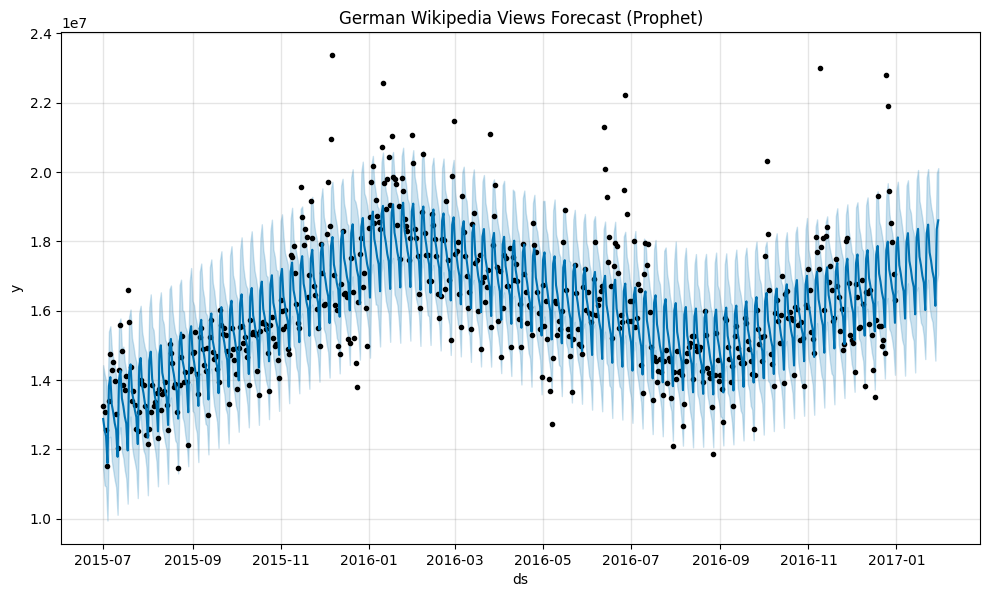


===== Forecasting for Japanese =====
Japanese | ADF: -2.6908, p-value: 0.0756


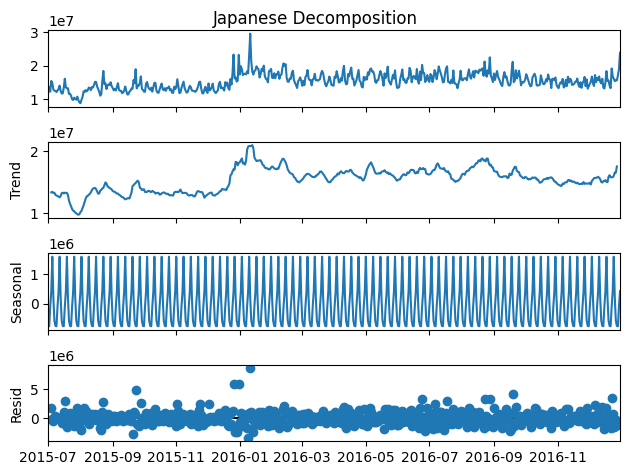

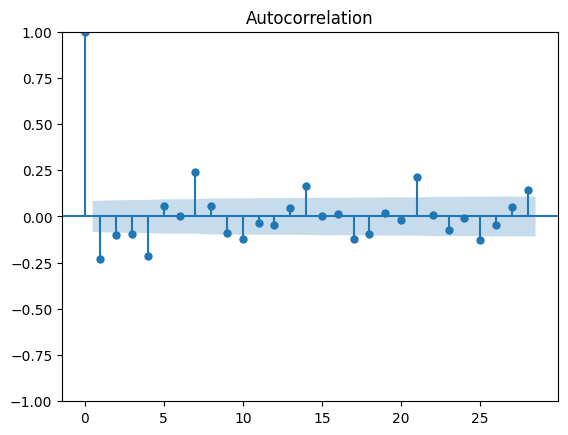

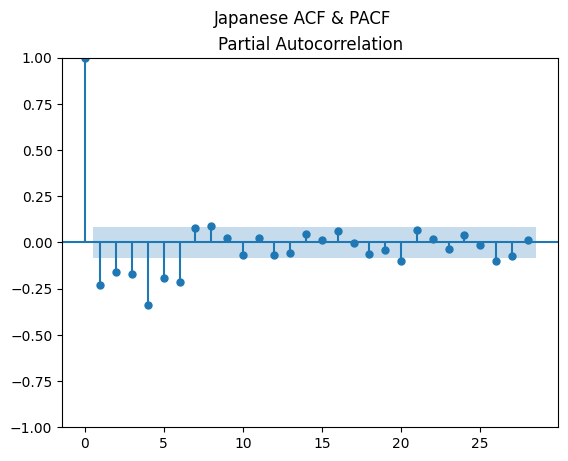

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8515.220
Date:                           Thu, 25 Sep 2025   AIC                          17040.439
Time:                                   14:12:33   BIC                          17061.915
Sample:                               07-01-2015   HQIC                         17048.837
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2966      0.109      2.730      0.006       0.084       0.510
ma.L1         -0.7077      0.093     -7.585

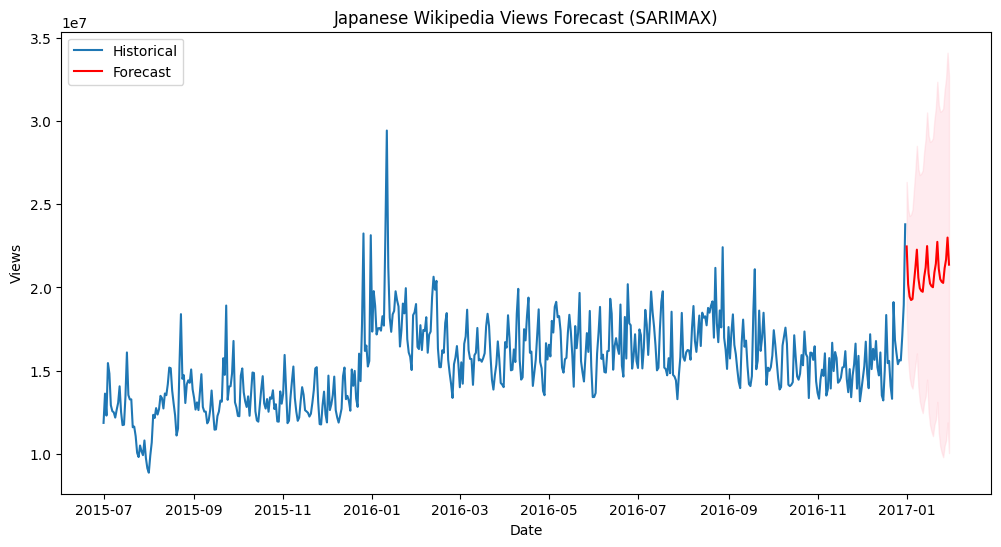

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/hkenyk8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/o1ixys1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4360', 'data', 'file=/tmp/tmpz_ik_iyh/hkenyk8_.json', 'init=/tmp/tmpz_ik_iyh/o1ixys1d.json', 'output', 'file=/tmp/tmpz_ik_iyh/prophet_modelflc4cw4h/prophet_model-20250925141233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


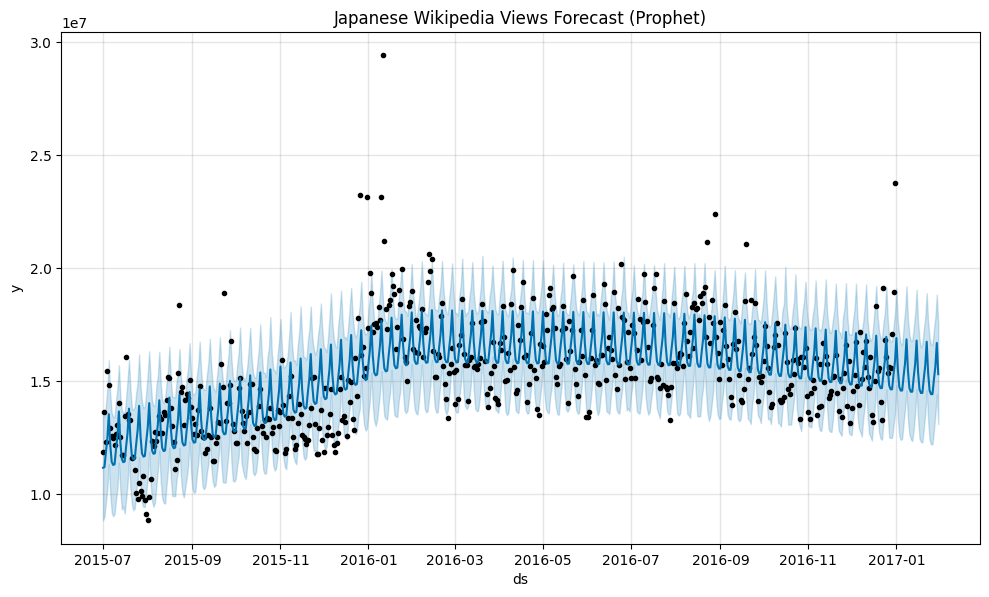


===== Forecasting for Spanish =====
Spanish | ADF: -2.9290, p-value: 0.0421


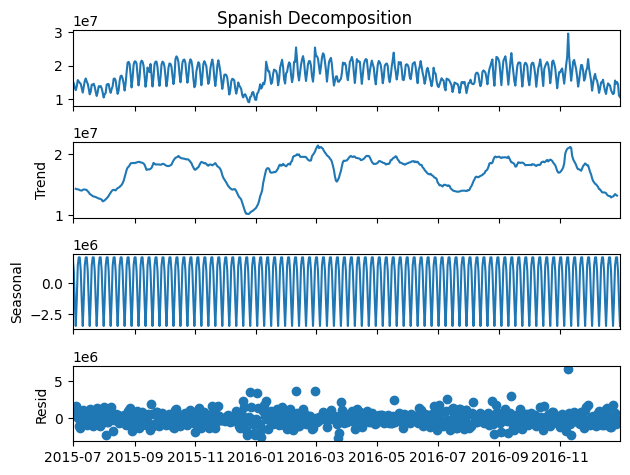

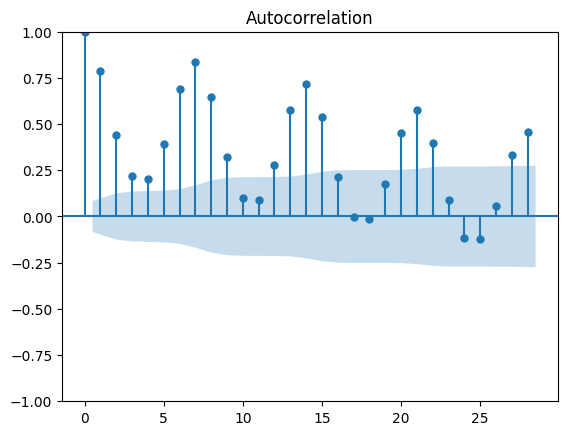

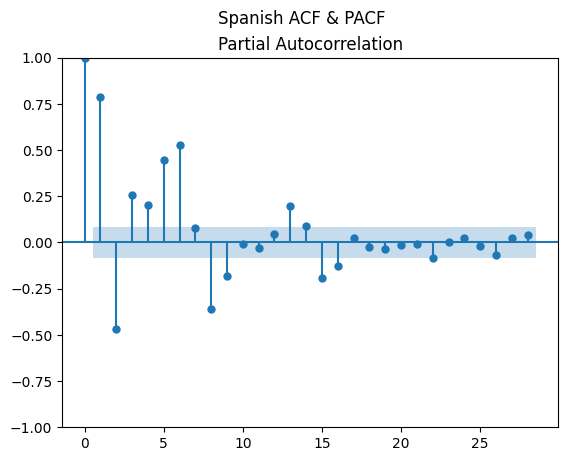

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8352.605
Date:                           Thu, 25 Sep 2025   AIC                          16715.209
Time:                                   14:12:36   BIC                          16736.685
Sample:                               07-01-2015   HQIC                         16723.607
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6264      0.128      4.893      0.000       0.375       0.877
ma.L1         -0.7963      0.111     -7.198

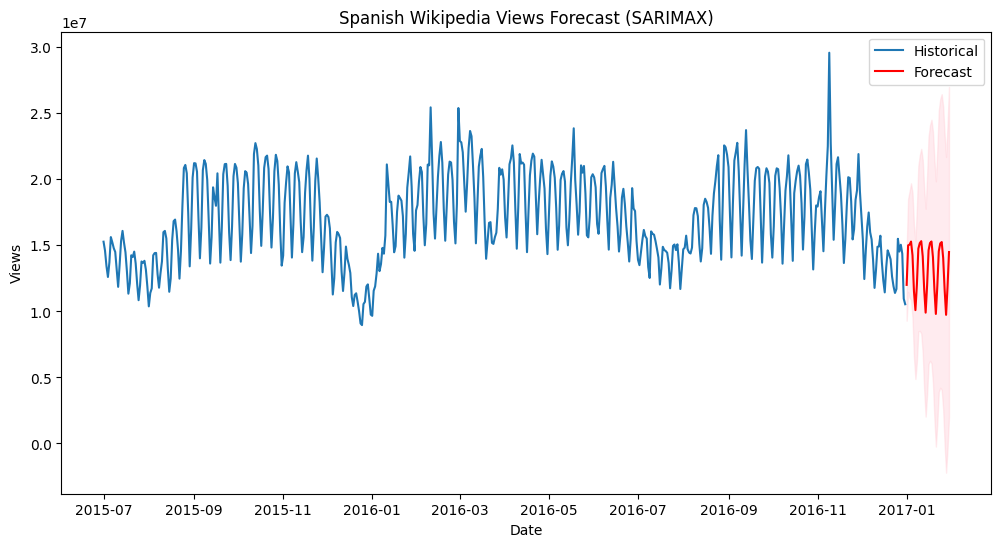

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/02c1j9vj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_ik_iyh/nounw0g_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35425', 'data', 'file=/tmp/tmpz_ik_iyh/02c1j9vj.json', 'init=/tmp/tmpz_ik_iyh/nounw0g_.json', 'output', 'file=/tmp/tmpz_ik_iyh/prophet_modelc337vqcp/prophet_model-20250925141236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:12:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:12:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


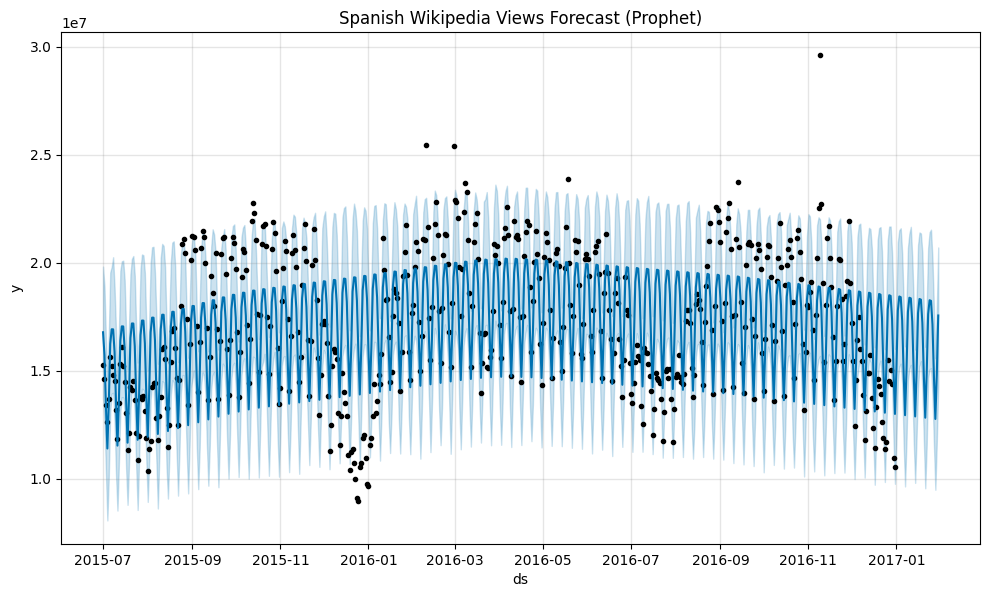

In [27]:
# --- Date columns ---
date_cols = [col for col in df_cleaned.columns if col[:4].isdigit()]

# --- Process each language except English & Unknown ---
languages = df_cleaned['Language_Full'].unique()
languages = [lang for lang in languages if lang not in ['English', 'Unknown']]

for lang in languages:
    print(f"\n===== Forecasting for {lang} =====")

    # Filter language pages
    df_lang = df_cleaned[df_cleaned['Language_Full'] == lang]

    # Aggregate views
    ts_lang = df_lang[date_cols].sum()
    ts_lang.index = pd.to_datetime(ts_lang.index)

    # --- Stationarity check ---
    result = adfuller(ts_lang)
    print(f'{lang} | ADF: {result[0]:.4f}, p-value: {result[1]:.4f}')
    ts_diff = ts_lang.diff().dropna() if result[1] > 0.05 else ts_lang.copy()

    # --- Decomposition ---
    decomp = seasonal_decompose(ts_lang, model='additive', period=seasonal_period)
    decomp.plot()
    plt.suptitle(f'{lang} Decomposition')
    plt.show()

    # --- ACF & PACF ---
    plot_acf(ts_diff)
    plot_pacf(ts_diff)
    plt.suptitle(f'{lang} ACF & PACF')
    plt.show()

    # --- SARIMAX modeling (no exog for non-English) ---
    model = SARIMAX(ts_lang, order=(1,1,1), seasonal_order=(1,1,1,seasonal_period))
    result_sarimax = model.fit(disp=False)
    print(result_sarimax.summary())

    # Forecast
    forecast = result_sarimax.get_forecast(steps=forecast_steps)
    forecast_df = forecast.summary_frame()

    plt.figure(figsize=(12,6))
    plt.plot(ts_lang, label='Historical')
    plt.plot(forecast_df['mean'], label='Forecast', color='red')
    plt.fill_between(
        forecast_df.index,
        forecast_df['mean_ci_lower'],
        forecast_df['mean_ci_upper'],
        color='pink',
        alpha=0.3
    )
    plt.title(f'{lang} Wikipedia Views Forecast (SARIMAX)')
    plt.xlabel('Date')
    plt.ylabel('Views')
    plt.legend()
    plt.show()

    # --- Prophet modeling ---
    prophet_df = pd.DataFrame({'ds': ts_lang.index, 'y': ts_lang.values})
    m = Prophet()
    m.fit(prophet_df)

    future = m.make_future_dataframe(periods=forecast_steps)
    forecast_prophet = m.predict(future)
    fig = m.plot(forecast_prophet)
    plt.title(f'{lang} Wikipedia Views Forecast (Prophet)')
    plt.show()
